In [1]:
# %load main.py
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from helper import *
from tqdm import tnrange, tqdm_notebook

/home/tianning/.local/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/home/tianning/.local/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/home/tianning/.local/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p
/home/tianning/.local/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/tianning/.local/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWar

In [2]:
MODEL_PATH="/media/tianning/DATA/Pre_Model/SketchKeras/mod.h5"
mod = load_model(MODEL_PATH)

## Show

#### function

In [3]:
def get_sketch(image,threshold=0.07):
    from_mat=image
    width = float(from_mat.shape[1])
    height = float(from_mat.shape[0])
    new_width = 0
    new_height = 0
    if (width > height):
        from_mat = cv2.resize(from_mat, (512, int(512 / width * height)), interpolation=cv2.INTER_AREA)
        new_width = 512
        new_height = int(512 / width * height)
    else:
        from_mat = cv2.resize(from_mat, (int(512 / height * width), 512), interpolation=cv2.INTER_AREA)
        new_width = int(512 / height * width)
        new_height = 512
    from_mat = from_mat.transpose((2, 0, 1))
    light_map = np.zeros(from_mat.shape, dtype=np.float)
    for channel in range(3):light_map[channel] = get_light_map_single(from_mat[channel])
    light_map = normalize_pic(light_map)
    light_map = resize_img_512_3d(light_map)
    line_mat = mod.predict(light_map, batch_size=1)
    line_mat = line_mat.transpose((3, 1, 2, 0))[0]
    line_mat = line_mat[0:int(new_height), 0:int(new_width), :]
    line_mat = np.amax(line_mat, 2)
    
    return recover(line_mat,threshold)

#### main code

In [4]:
basedir="/media/tianning/DATA/human_data_sets/CAF/"
test_paths=under_file(basedir)

In [5]:
# basedir="/media/tianning/DATA/human_data_sets/HD-CelebA-Cropper/path_to_dataset/data_crop_256_jpg/"
# test_paths=under_file(basedir)
# imagepaths=test_paths

# basedir_o="/media/tianning/DATA/human_data_sets/HD-CelebA-Cropper/path_to_dataset/data/"
# test_paths_o=under_file(basedir_o)
# imagepaths_o=test_paths_o

In [6]:
image=cv2.imread(test_paths[1])

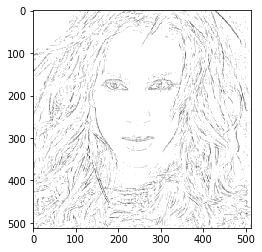

In [7]:
sketch = get_sketch(image)
gray_print(sketch)

In [74]:
# leng=len(imagepaths)
# for i in tnrange(leng, desc='1st loop'):
#     path=imagepaths[i]
#     image=cv2.imread(path)
#     w,h,_=image.shape
#     sketch = get_sketch(image,0.07)
#     _=cv2.imwrite("/media/tianning/DATA/sketch_super_resolution/512/source_"+str(i)+'.jpg',image)
#     _=cv2.imwrite("/media/tianning/DATA/sketch_super_resolution/512/target_"+str(i)+'.jpg',sketch)

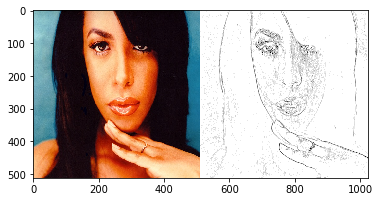

In [24]:
image=cv2.imread(imagepaths[num])
w,h,_=image.shape
sketch  =get_sketch(image,0.);
row1=np.concatenate([image,sketch],axis=1)
row2=np.concatenate([edge,edge2],axis=1)
combine=np.concatenate([row1,row2])
cv2.imwrite('test.jpg',row1)
rgb_print(row1)

## Post-Train

#### function

In [5]:
def unifsize(image):
    from_mat=image
    width = float(from_mat.shape[1])
    height = float(from_mat.shape[0])
    new_width = 0
    new_height = 0
    if (width > height):
        from_mat = cv2.resize(from_mat, (512, int(512 / width * height)), interpolation=cv2.INTER_AREA)
        new_width = 512
        new_height = int(512 / width * height)
    else:
        from_mat = cv2.resize(from_mat, (int(512 / height * width), 512), interpolation=cv2.INTER_AREA)
        new_width = int(512 / height * width)
        new_height = 512
    return from_mat

def pre_process_inp(image):
    from_mat = unifsize(image)
    from_mat = from_mat.transpose((2, 0, 1))
    light_map = np.zeros(from_mat.shape, dtype=np.float)
    for channel in range(3):light_map[channel] = get_light_map_single(from_mat[channel])
    light_map = normalize_pic(light_map)
    light_map = resize_img_512_3d(light_map)
    return light_map

def rotate(image, angle, center=None, scale=1.0):
    # 获取图像尺寸
    (h, w) = image.shape[:2]
    if center is None:center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def add_data(pair):
    photo,sketch=pair
    #angle=np.floor(np.random.rand()*360)
    #photo = rotate(photo,angle)
    #sketch= rotate(sketch,angle)
    if np.random.rand() > 0.5:
        photo = cv2.flip(photo, 1)
        sketch = cv2.flip(sketch, 1)
    if np.random.rand() > 0.5:
        photo = cv2.flip(photo, 0)
        sketch = cv2.flip(sketch, 0)
    return check_input_form_single(photo),check_input_form_single(sketch)

def check_input_form_single(image):
    shape=image.shape
    dim  = len(shape)
    if dim == 3:
        a,b,c = shape
        if a==1:image=image.reshape(a,b,c,1)
        if c==1:image=image.reshape(1,a,b,c)
        if b==1:raise NotImplementedError("bad image:a,b,c=shape;b=1")
    if dim == 2:
        a,b = shape
        image=image.reshape(1,a,b,1)
    a,b,c,d=image.shape
    if a==1 and d==1 and b==c and b>1:
        return image
    else:
        raise NotImplementedError("bad image size:(%d,%d,%d,%d)" %(a,b,c,d))

def get_sample(dataset,batch_size):
    np.random.shuffle(dataset)
    inps=[]
    outs=[]
    for i in range(batch_size):
        inp,out= add_data(dataset[i])
        inps.append(inp)
        outs.append(out)
    return np.concatenate(inps),np.concatenate(outs)

#### for human reinfore train
def get_sample_from_path(dataset,batch_size):
    np.random.shuffle(dataset)
    inps=[]
    outs=[]

    for i in range(batch_size):
        photo_path,sketch_path=dataset[i]
        photo_o = cv2.imread(photo_path)
        sketch_o= cv2.imread(sketch_path)
        photo   = pre_process_inp(photo_o)
        sketch  = get_gray_map(unifsize(sketch_o))
        sketch  = resize_img_512(sketch)
        ch=np.random.randint(0,3)
        try:
            inp,out= add_data([photo[ch],sketch])
            inps.append(inp)
            outs.append(out)
        except:
            print(i)
    return np.concatenate(inps),np.concatenate(outs)

#### Main code

In [6]:
DATA_PATH_1="/media/tianning/DATA/human_data_sets/CUHK/sketches/"
DATA_PATH_2="/media/tianning/DATA/human_data_sets/CUHK/photos/"
photo_names=[name.split('.')[0] for name in os.listdir(DATA_PATH_2)]

In [7]:
#####################
####load path########
#####################
file_dir=DATA_PATH_2
for filename in os.listdir(file_dir):
    filename_s=filename.lower()
    filepath=os.path.join(file_dir,filename)
    filepath_s=os.path.join(file_dir,filename_s)
    os.rename(filepath,filepath_s)

pair_paths=[]
for name in photo_names:
    photo_path =os.path.join(DATA_PATH_2,name+'.jpg')
    sketch_path=os.path.join(DATA_PATH_1,name+'-sz1.jpg')
    if os.path.exists(sketch_path):
        pair_paths.append((photo_path,sketch_path))

data_dir="/media/tianning/DATA/anime_data_sets/pixiv_data/pair_128/"
pair_list=os.listdir(data_dir)
leng=len(pair_list)/2
output={}
for name in pair_list:
    num,sign=name.strip().split("_")
    sign=sign.strip('.')[0]
    path=os.path.join(data_dir,name)
    if num not in output:output[num]={}
    output[num][sign]=path
other=[[output[key]['g'],output[key]['c']] for key in output]    
combine_path=pair_paths[:]
combine_path.extend(other[:500])        

image_pair=[]
for photo_path,sketch_path in pair_paths:
    photo=pre_process_inp(cv2.imread(photo_path))
    sketch=resize_img_512(get_light_map(cv2.imread(sketch_path)))
    R,G,B =photo
    image_pair.append([R,sketch])
    image_pair.append([G,sketch])
    image_pair.append([B,sketch])

In [10]:
basedir="/media/tianning/DATA/human_data_sets/CAF/"
test_paths=under_file(basedir)

In [15]:
anime_paths=other

In [19]:
train_picked=np.random.randint(0,len(pair_paths),(3,3));
test_picked =np.random.randint(0,len(test_paths),(3,3));
anime_picked=np.random.randint(0,len(anime_paths),(3,3));

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [36]:
MODEL_PATH="/media/tianning/DATA/Pre_Model/SketchKeras/mod.h5"
mod = load_model(MODEL_PATH)

In [37]:
anime_grab=grab_pic(train_look,anime_paths,anime_picked)

In [38]:
tot_epch=10000
write_epch=100
save_epch=1000
for i in tnrange(tot_epch, desc='1st loop'):
    #inp,tar=get_sample(image_pair,4)
    inp,tar=get_sample_from_path(combine_path,7)
    loss   =mod.train_on_batch(inp,tar)
    if i%write_epch == 0:
        train_grab=grab_pic(train_look,pair_paths,train_picked)
        test_grab=grab_pic(test_look,test_paths,train_picked)
        anime_grab=grab_pic(train_look,anime_paths,anime_picked)
        cv2.imwrite('image/train_look_'+str(i)+'.jpg',train_grab)
        cv2.imwrite('image/test_look_'+str(i)+'.jpg',test_grab)
        cv2.imwrite('image/test_look_'+str(i)+'.jpg',anime_grab)
    if i%save_epch == save_epch-1:mod.save('save_model/my_model_'+str(i)+'.h5')
    with open('log','w') as f:
        f.write(i)
cv2.imwrite('image/train_look_'+str(i)+'.jpg',train_grab)
cv2.imwrite('image/test_look_'+str(i)+'.jpg',test_grab)
cv2.imwrite('image/test_look_'+str(i)+'.jpg',anime_grab)

ResourceExhaustedError: OOM when allocating tensor with shape[7,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/conv2d_18/Conv2D_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/conv2d_18/Conv2D_grad/ShapeN, conv2d_18/Conv2D/ReadVariableOp, training/Adam/gradients/conv2d_18/Conv2D_grad/Conv2DBackpropFilter-2-TransposeNHWCToNCHW-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
